In [1]:
import numpy as np
import matplotlib.pyplot as plt

## hadamard

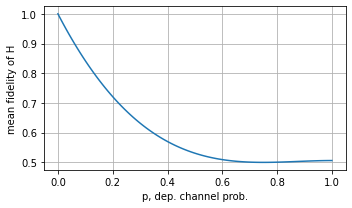

In [102]:
p = np.linspace(0,1,100)
p_flip = 2*p/3
p00 = (1-p_flip)**4 + 2*p_flip**3 * (1-p_flip) + p_flip**2 * (1-p_flip)**2 
p01 = 2*p_flip * (1-p_flip)**3 + p_flip**2 * (1-p_flip)**2 + p_flip**4
p10 = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
p11 = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)

# plt.plot(p,p00+p01+p11+p10)

F_avg = 0.5 + (3*p00-p01-p10-p11)/6 ## Eq.(18) of quant-ph/0205035
plt.figure(figsize=(5,3))
plt.plot(p,F_avg)
plt.xlabel("p, dep. channel prob.")
plt.ylabel("mean fidelity of H")
plt.grid()
plt.tight_layout()
plt.savefig("figs/fidelity_H.pdf")
plt.show()

## two-qubit RB

In [172]:

p_flip = 1e-3

## hadmard error rates
p00 = (1-p_flip)**4 + 2*p_flip**3 * (1-p_flip) + p_flip**2 * (1-p_flip)**2 
p01 = 2*p_flip * (1-p_flip)**3 + p_flip**2 * (1-p_flip)**2 + p_flip**4
p10 = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
p11 = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
elements = [0,1,2,3]
prob_hadamard = [p00,p01,p10,p11]

# vec_err = np.copy(vec)

Nq = 2
Ndepth_list = np.arange(10,101,10)
Nrep = 1000
err_val = np.zeros((Nrep,len(Ndepth_list)),dtype=np.complex64)
err_avg = np.zeros(len(Ndepth_list),dtype=np.complex64)
for i_Nd, Ndepth in enumerate(Ndepth_list): 
    print("circ. depth = ", Ndepth)
    for i_r in range(Nrep):
        vec = np.array([[0,0,1,0],[0,0,0,1]],dtype=int) ##  [ X1 X2|Z1 Z2 ]
        vec_eval = np.array([1,1])

        vec_err_eval = np.array([1,1])
        for iter in range(Ndepth):
            if np.random.rand()<0.5:
                ## cnot
                if np.random.rand()<0.5:
                    ## control: 1
                    vec[:,1]= np.mod(vec[:,1]+vec[:,0],2)
                    vec[:,2]= np.mod(vec[:,3]+vec[:,2],2)
                    control = 0
                    target = 1
                else:
                    ## control: 2
                    vec[:,0]= np.mod(vec[:,0]+vec[:,1],2)
                    vec[:,3]= np.mod(vec[:,3]+vec[:,2],2)
                    control = 1
                    target = 0

                inds = np.argwhere(np.random.rand(15)< p_flip)[:,0]
                s_flip = np.zeros(15)
                s_flip[inds]= 1
                sz_c = (1+np.sum(s_flip[[1,3,4,5,8,13]])) %2
                sx_c = np.sum(s_flip[[2,3,5,6]])%2
                sz_t = np.sum(s_flip[[9,11,13]])%2
                sx_t = np.sum(s_flip[[5,6,8,10,12,14]])%2
                if sz_c > 0 :
                    vec_err_eval = (-1)**vec[:,control] * vec_err_eval
                if sx_c > 0 :
                    vec_err_eval = (-1)**vec[:,control+Nq] * vec_err_eval
                if sz_t > 0 :
                    vec_err_eval = (-1)**vec[:,target] * vec_err_eval
                if sx_t > 0 :
                    vec_err_eval = (-1)**vec[:,target+Nq] * vec_err_eval

            else:
                for qubit in range(Nq):
                    randgate = np.random.randint(0,3)
                    if randgate==0:
                        ## hadamard
                        err1 = np.random.choice(elements, 1, p=prob_hadamard)
                        if err1==1:
                            ## Z
                            vec_err_eval = (-1)**vec[:,qubit] * vec_err_eval
                        elif err1==2:
                            ## X
                            vec_err_eval = (-1)**vec[:,qubit+Nq] * vec_err_eval
                        elif err1==3:
                            ## XZ
                            vec_err_eval = (-1)**(vec[:,qubit]+vec[:,qubit+Nq]) * vec_err_eval

                        # vec_err[:,qubit], vec_err[:,qubit+Nq] = vec_err[:,qubit+Nq], vec_err[:,qubit] 

                        vec[:,qubit], vec[:,qubit+Nq] = vec[:,qubit+Nq], vec[:,qubit] 
                    elif randgate==1:
                        ## phase
                        err1 = np.random.choice(elements, 1, p=prob_hadamard)
                        if err1==1:
                            ## Z
                            vec_err_eval = (-1)**vec[:,qubit] * vec_err_eval
                        elif err1==2:
                            ## X
                            vec_err_eval = (-1)**vec[:,qubit+Nq] * vec_err_eval
                        elif err1==3:
                            ## XZ
                            vec_err_eval = (-1)**(vec[:,qubit]+vec[:,qubit+Nq]) * vec_err_eval

                        # vec_err_eval = 1j*(1-(vec[:,qubit+Nq]* vec[:,qubit]))*vec_err_eval + (vec[:,qubit+Nq]* vec[:,qubit])*vec_err_eval
                        vec_err_eval = (1-vec[:,qubit])*vec_err_eval + 1j*vec[:,qubit]*vec_err_eval

                        # vec_eval = (1-(vec[:,qubit+Nq]* vec[:,qubit]))*vec_eval + 1j*(vec[:,qubit+Nq]* vec[:,qubit])*vec_eval
                        vec_eval = (1-vec[:,qubit])*vec_eval + 1j*vec[:,qubit]*vec_eval
                        vec[:,qubit+Nq] = np.mod(vec[:,qubit+Nq]+ vec[:,qubit],2)

                    # else: # identity
        # amp = (-1)**np.sum(vec[:,:Nq]*vec[:,Nq:],axis=0)
        # Stot = np.sum(vec,axis=0)%2
        # amp_prod = (-1)**np.sum(Stot[:Nq]*Stot[Nq:])
        # err_val[i_r,i_Nd] = 1+ (vec_eval*vec_err_eval)@amp + np.prod(vec_eval)*np.prod(vec_err_eval)*amp_prod
        err_val[i_r,i_Nd] = 1+ (np.conj(vec_eval)@vec_err_eval) + np.conj(np.prod(vec_eval))*np.prod(vec_err_eval)
        # err_val[i_r,i_Nd] = 1+ (np.conj(vec_eval)@vec_eval) + np.conj(np.prod(vec_eval))*np.prod(vec_eval)
    # err_avg[i_Nd] = np.mean(err_val)
    # print(vec_eval,vec_err_eval)



circ. depth =  10
circ. depth =  20
circ. depth =  30
circ. depth =  40
circ. depth =  50
circ. depth =  60
circ. depth =  70
circ. depth =  80
circ. depth =  90
circ. depth =  100


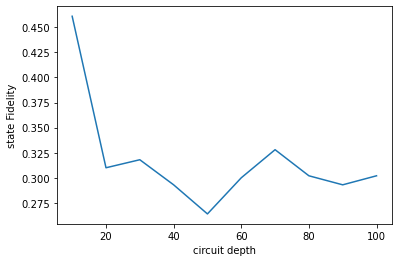

In [175]:
# plt.plot(Ndepth_list,np.real(err_val).T,"o")
plt.plot(Ndepth_list,np.mean(np.abs(err_val)**0.5,axis=0).T/2,"-")
# plt.plot(Ndepth_list,np.imag(err_val).T,"o")
plt.xlabel("circuit depth")
plt.ylabel("state Fidelity")
plt.show()
# print(err_val[:,1])

## three qubits

In [40]:
p_flip = 1e-9

## hadmard error rates
p00 = (1-p_flip)**4 + 2*p_flip**3 * (1-p_flip) + p_flip**2 * (1-p_flip)**2 
p01 = 2*p_flip * (1-p_flip)**3 + p_flip**2 * (1-p_flip)**2 + p_flip**4
p10 = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
p11 = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
elements = [0,1,2,3]
prob_hadamard = [p00,p01,p10,p11]

Nq = 2
Ndepth_list = np.arange(0,10,1)
Nrep = 1000
err_val = np.zeros((len(Ndepth_list),Nrep),dtype=np.complex64)
err_avg = np.zeros(len(Ndepth_list),dtype=np.complex64)
for i_Nd, Ndepth in enumerate(Ndepth_list): 
    print("circ. depth = ", Ndepth)
    for i_r in range(Nrep):
        vec = np.concatenate((np.zeros((Nq,Nq)),np.eye(Nq)),axis=1) ##  [ X1 X2 X3|Z1 Z2 Z3]
        vec_eval = np.ones(Nq)
        vec_err_eval = np.ones(Nq)
        
        for iter in range(Ndepth):
            # q_remaining = list(set(np.arange(Nq))-set([target,control]))
            for qubit in range(Nq):
                randgate = np.random.randint(0,3)
                if randgate==0:
                    ## hadamard
                    err1 = np.random.choice(elements, 1, p=prob_hadamard)
                    if err1==1:
                        ## Z
                        vec_err_eval = (-1)**vec[:,qubit] * vec_err_eval
                    elif err1==2:
                        ## X
                        vec_err_eval = (-1)**vec[:,qubit+Nq] * vec_err_eval
                    elif err1==3:
                        ## XZ
                        vec_err_eval = (-1)**(vec[:,qubit]+vec[:,qubit+Nq]) * vec_err_eval

                    vec[:,qubit], vec[:,qubit+Nq] = vec[:,qubit+Nq], vec[:,qubit] 
                elif randgate==1:
                    ## phase
                    err1 = np.random.choice(elements, 1, p=prob_hadamard)
                    if err1==1:
                        ## Z
                        vec_err_eval = (-1)**vec[:,qubit] * vec_err_eval
                    elif err1==2:
                        ## X
                        vec_err_eval = (-1)**vec[:,qubit+Nq] * vec_err_eval
                    elif err1==3:
                        ## XZ
                        vec_err_eval = (-1)**(vec[:,qubit]+vec[:,qubit+Nq]) * vec_err_eval

                    vec_err_eval = (1-vec[:,qubit])*vec_err_eval + 1j*vec[:,qubit]*vec_err_eval

                    vec_eval = (1-vec[:,qubit])*vec_eval + 1j*vec[:,qubit]*vec_eval
                    vec[:,qubit+Nq] = np.mod(vec[:,qubit+Nq]+ vec[:,qubit],2)
                    
            q_new = np.random.permutation(Nq)
            for pair in range(int(Nq/2)):
                control = q_new[2*pair]
                target = q_new[2*pair+1]            

                inds = np.argwhere(np.random.rand(15)< p_flip)[:,0]
                s_flip = np.zeros(15)
                s_flip[inds]= 1
                sz_c = (1+np.sum(s_flip[[1,3,4,5,8,13]])) %2
                sx_c = np.sum(s_flip[[2,3,5,6]])%2
                sz_t = np.sum(s_flip[[9,11,13]])%2
                sx_t = np.sum(s_flip[[5,6,8,10,12,14]])%2
                if sz_c > 0 :
                    vec_err_eval = (-1)**vec[:,control] * vec_err_eval
                if sx_c > 0 :
                    vec_err_eval = (-1)**vec[:,control+Nq] * vec_err_eval
                if sz_t > 0 :
                    vec_err_eval = (-1)**vec[:,target] * vec_err_eval
                if sx_t > 0 :
                    vec_err_eval = (-1)**vec[:,target+Nq] * vec_err_eval
                    
                ## cnot
                vec[:,target]= np.mod(vec[:,target]+vec[:,control],2)
                vec[:,control+Nq]= np.mod(vec[:,target+Nq]+vec[:,control+Nq],2)

                # else: # identity
        err_val[i_Nd,i_r] = np.prod(1+ np.conj(vec_eval)*vec_err_eval)/2**Nq 



circ. depth =  0
circ. depth =  1
circ. depth =  2
circ. depth =  3
circ. depth =  4
circ. depth =  5
circ. depth =  6
circ. depth =  7
circ. depth =  8
circ. depth =  9


In [37]:
vec

array([[1., 1., 0., 0., 1., 1., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1.]])

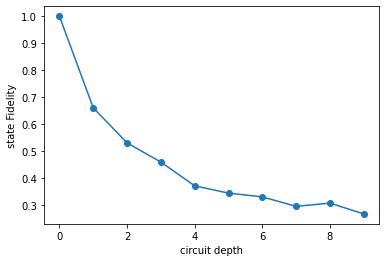

In [41]:
# plt.plot(Ndepth_list,np.real(err_val),"o")
plt.plot(Ndepth_list,np.mean(np.abs(err_val)**0.5,axis=1),"o-")
# plt.plot(Ndepth_list,np.imag(err_val),"o")
plt.xlabel("circuit depth")
plt.ylabel("state Fidelity")
plt.show()
# print(err_val[:,1])

## qiskit

In [92]:
# Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

# Import Qiskit classes 
import qiskit
from qiskit import assemble, transpile
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

# Generate RB circuits (2Q RB)

# number of qubits
nQ = 3 
rb_opts = {}
#Number of Cliffords in the sequence
rb_opts['length_vector'] = [1, 10, 20, 50, 75, 100, 125, 150, 175, 200]
# Number of seeds (random sequences)
rb_opts['nseeds'] = 5
# Default pattern
rb_opts['rb_pattern'] = [[0, 1, 2]]

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

In [93]:
rb_circs[0][0].draw()

┌─────┐ ┌───┐      ┌───┐┌───┐     ┌─────┐┌───┐                ░  ┌───┐ »
qr_0: ┤ Sdg ├─┤ H ├───■──┤ H ├┤ S ├──■──┤ Sdg ├┤ H ├────────────────░──┤ H ├─»
      └┬───┬┘ ├───┤ ┌─┴─┐└───┘└───┘  │  └─────┘└───┘     ┌───┐┌───┐ ░ ┌┴───┴┐»
qr_1: ─┤ Z ├──┤ H ├─┤ X ├────────────┼────────────────■──┤ H ├┤ S ├─░─┤ Sdg ├»
       ├───┤ ┌┴───┴┐├───┤          ┌─┴─┐ ┌───┐ ┌───┐┌─┴─┐└───┘└───┘ ░ └─────┘»
qr_2: ─┤ X ├─┤ Sdg ├┤ H ├──────────┤ X ├─┤ H ├─┤ S ├┤ X ├───────────░────────»
       └───┘ └─────┘└───┘          └───┘ └───┘ └───┘└───┘           ░        »
cr: 3/═══════════════════════════════════════════════════════════════════════»
                                                                             »
«      ┌───┐                      ┌─────┐┌───┐     ┌───┐┌───┐┌─┐   
«qr_0: ┤ S ├───────────────────■──┤ Sdg ├┤ H ├──■──┤ H ├┤ S ├┤M├───
«      ├───┤                   │  └─────┘└───┘┌─┴─┐├───┤├───┤└╥┘┌─┐
«qr_1: ┤ H ├──■────────────────┼──────────────┤ X ├┤ H ├┤ Z ├─╫─┤M├
«      └───┘┌─┴─┐┌─────┐┌───┐┌─┴─┐ ┌───┐ ┌───┐├───┤└┬─┬┘└───┘ ║ └╥┘
«qr_2: ─────┤ X ├┤ Sdg ├┤ H ├┤ X ├─┤ H ├─┤ S ├┤ X ├─┤M├───────╫──╫─
«           └───┘└─────┘└───┘└───┘ └───┘ └───┘└───┘ └╥┘       ║  ║ 
«cr: 3/══════════════════════════════════════════════╩════════╩══╩═
«                                                    2        0  1

In [94]:
# Create a new circuit without the measurement
qregs = rb_circs[0][-1].qregs
cregs = rb_circs[0][-1].cregs
qc = qiskit.QuantumCircuit(*qregs, *cregs)
for i in rb_circs[0][-1][0:-nQ]:
    qc.data.append(i)

In [95]:
# The Unitary is an identity (with a global phase)
sim = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
qc.save_unitary()
unitary = sim.run(qc).result().get_unitary()
from qiskit.visualization import array_to_latex
array_to_latex(unitary, prefix="\\text{Unitary} = ")

<IPython.core.display.Latex object>

In [96]:
# Run on a noisy simulator
noise_model = NoiseModel()

# Depolarizing error on the gates u2, u3 and cx (assuming the u1 is virtual-Z gate and no error)
# p1Q = 0.02
# p2Q = 0.01

p_flip = 0.001
## hadmard error rates
p00 = (1-p_flip)**4 + 2*p_flip**3 * (1-p_flip) + p_flip**2 * (1-p_flip)**2 
p01 = 2*p_flip * (1-p_flip)**3 + p_flip**2 * (1-p_flip)**2 + p_flip**4
p10 = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
p11 = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
bit_flip = pauli_error([('I', p00), ('Z', p01), ('X', p10), ('Y', p11)])

noise_model.add_all_qubit_quantum_error(bit_flip, 'u2')
noise_model.add_all_qubit_quantum_error(bit_flip, 'u3')


def Hilbertspace_Zr(N,r):
    states=np.zeros((r**N,N),dtype=int)
    if N>0:
        for i_1 in range(r**N):
            num_str=np.base_repr(i_1,base=r)[::-1]
            for i_2 in range(len(num_str)):
                states[i_1,i_2]=int(num_str[i_2])
    else:
        states=[[0]]
        
    return states

Nq = 14
vec = Hilbertspace_Zr(Nq,2)
err_vec = np.zeros((16,Nq+1),dtype=int)
for i in range(2**Nq):
    s_flip=vec[i,:]
    sz_c = np.sum(vec[i,[0,2,3,4,7,12]])
    sx_c = np.sum(vec[i,[1,2,4,5]])
    sz_t = np.sum(vec[i,[8,10,12]])
    sx_t = np.sum(vec[i,[4,5,7,9,11,13]])
    p_exp = np.sum(vec[i,:])
    
    i_e = np.array([sz_c%2,sx_c%2,sz_t%2,sx_t%2])@ (2**np.arange(4))
    err_vec[i_e,p_exp] += 1
    
p_vec = p_flip**np.arange(15)*(1-p_flip)**np.arange(14,-1,-1)
err_prob = err_vec @ p_vec
pauli_vec = Hilbertspace_Zr(4,2)
pauli_combined = []
for i in range(16):
    p_st = ''
    p1 = pauli_vec[i,:2]@ np.array([1,2])
    if  p1 == 0:
        p_st += 'I'
    elif  p1 == 1:
        p_st += 'Z'
    elif  p1 == 2:
        p_st += 'X'
    else:
        p_st += 'Y'
    p2 = pauli_vec[i,2:]@ np.array([1,2])
    if  p2 == 0:
        p_st += 'I'
    elif  p2 == 1:
        p_st += 'Z'
    elif  p2 == 2:
        p_st += 'X'
    else:
        p_st += 'Y'

    pauli_combined.append((p_st,err_prob[i]))
print(pauli_combined)
two_bit_flip = pauli_error(pauli_combined)

noise_model.add_all_qubit_quantum_error(two_bit_flip, 'cx')

# noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
# noise_model.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), 'u3')
# noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

backend = qiskit.Aer.get_backend('aer_simulator')

[('II', 0.9870826818085957), ('ZI', 0.001983070826265748), ('XI', 0.000994018964041972), ('YI', 0.000994018964041972), ('IZ', 0.001978122592860813), ('ZZ', 0.000992036896181804), ('XZ', 2.985033958027992e-06), ('YZ', 2.985033958027992e-06), ('IX', 0.002968168463104517), ('ZX', 0.00099599904586618), ('XX', 0.000994018964041972), ('YX', 0.000994018964041972), ('IY', 6.939259343035e-06), ('ZY', 4.965115782235864e-06), ('XY', 2.985033958027992e-06), ('YY', 2.985033958027992e-06)]


In [97]:
# Create the RB fitter
backend = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] 
shots = 200
transpiled_circs_list = []
rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
for rb_seed, rb_circ_seed in enumerate(rb_circs):
    print(f'Compiling seed {rb_seed}')
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    transpiled_circs_list.append(new_rb_circ_seed)
    print(f'Simulating seed {rb_seed}')
    qobj = assemble(new_rb_circ_seed, shots=shots)
    job = backend.run(qobj,
                      noise_model=noise_model,
                      max_parallel_experiments=0)
    # Add data to the fitter
    rb_fit.add_data(job.result())
    print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))

Compiling seed 0
Simulating seed 0
After seed 0, alpha: 0.929959, EPC: 0.061286
Compiling seed 1
Simulating seed 1
After seed 1, alpha: 0.932236, EPC: 0.059293
Compiling seed 2
Simulating seed 2
After seed 2, alpha: 0.925412, EPC: 0.065265
Compiling seed 3
Simulating seed 3
After seed 3, alpha: 0.926731, EPC: 0.064110
Compiling seed 4
Simulating seed 4
After seed 4, alpha: 0.926376, EPC: 0.064421


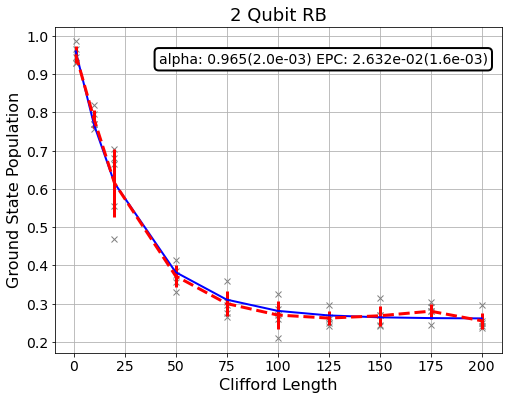

In [89]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rb_fit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit RB'%(nQ), fontsize=18)

plt.show()

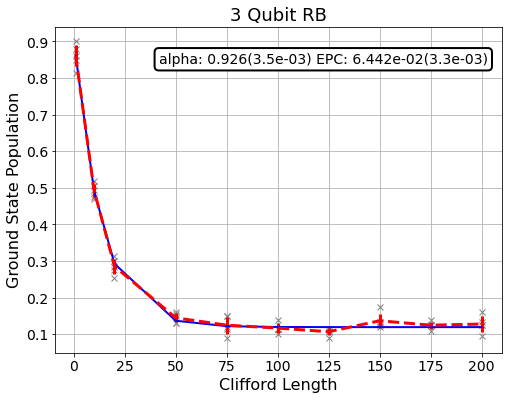

In [98]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rb_fit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit RB'%(nQ), fontsize=18)

plt.show()

In [14]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

In [33]:
# Construct a 1-qubit bit-flip and phase-flip errors
p_flip = 0.3
## hadmard error rates
p00 = (1-p_flip)**4 + 2*p_flip**3 * (1-p_flip) + p_flip**2 * (1-p_flip)**2 
p01 = 2*p_flip * (1-p_flip)**3 + p_flip**2 * (1-p_flip)**2 + p_flip**4
p10 = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
p11 = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
bit_flip = pauli_error([('I', p00), ('Z', p01), ('X', p10), ('Y', p11)])

# print(bit_flip)

two_bit_flip = pauli_error([('I', p00), ('XZ', p01), ('XZ', p10), ('YY', p11)])
print(two_bit_flip)





QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.32199999999999995, Circuit = 
     ┌────────────┐
q_0: ┤0           ├
     │  Pauli(IX) │
q_1: ┤1           ├
     └────────────┘
  P(1) = 0.258, Circuit = 
     ┌────────────┐
q_0: ┤0           ├
     │  Pauli(XZ) │
q_1: ┤1           ├
     └────────────┘
  P(2) = 0.21000000000000002, Circuit = 
     ┌────────────┐
q_0: ┤0           ├
     │  Pauli(XZ) │
q_1: ┤1           ├
     └────────────┘
  P(3) = 0.21000000000000002, Circuit = 
     ┌────────────┐
q_0: ┤0           ├
     │  Pauli(YY) │
q_1: ┤1           ├
     └────────────┘


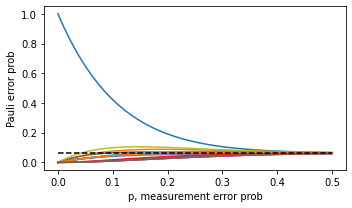

In [117]:
def Hilbertspace_Zr(N,r):
    states=np.zeros((r**N,N),dtype=int)
    if N>0:
        for i_1 in range(r**N):
            num_str=np.base_repr(i_1,base=r)[::-1]
            for i_2 in range(len(num_str)):
                states[i_1,i_2]=int(num_str[i_2])
    else:
        states=[[0]]
        
    return states

Nq = 14
vec = Hilbertspace_Zr(Nq,2)

z1 = np.zeros((2,Nq+1),dtype=int)
x1 = np.zeros((2,Nq+1),dtype=int)
z2 = np.zeros((2,Nq+1),dtype=int)
x2 = np.zeros((2,Nq+1),dtype=int)
err_vec = np.zeros((16,Nq+1),dtype=int)
for i in range(2**Nq):
    s_flip=vec[i,:]
    sz_c = np.sum(vec[i,[0,2,3,4,7,8,10]])
    sx_c = np.sum(vec[i,[1,2,4,5]])
    sz_t = np.sum(vec[i,[8,10,12]])
    sx_t = np.sum(vec[i,[1,2,7,9,11,13]])
    p_exp = np.sum(vec[i,:])
    
    i_e = np.array([sz_c%2,sx_c%2,sz_t%2,sx_t%2])@ (2**np.arange(4))
    err_vec[i_e,p_exp] += 1
    # z1[(sz_c+1)%2,p_exp] += 1
    # x1[sx_c%2,p_exp] += 1
    # z2[sz_t%2 ,p_exp] += 1
    # x2[sx_t%2,p_exp] += 1
    
# print(x1[1,:])
# print(z1[1,:])
# print(x2[1,:])
# print(z2[1,:])

p_list = np.linspace(0,1/3)
err_prob = np.zeros((16,len(p_list)))
for i_p, p in enumerate(p_list):
    p_vec = p**np.arange(15)*(1-p)**np.arange(14,-1,-1)
    err_prob[:,i_p] = err_vec @ p_vec
    
plt.figure(figsize=(5,3))
for i_e in range(16):
    plt.plot(3/2*p_list,err_prob[i_e,:],label="%d" % i_e)
# plt.plot(p_list,np.sum(err_prob,axis=0))
plt.plot(3/2*p_list,p_list*0+1/16,"k--")
plt.ylabel("Pauli error prob")
plt.xlabel("p, measurement error prob")
plt.tight_layout()
plt.savefig("figs/err_prob_cnot.pdf")
# plt.legend()
plt.show()

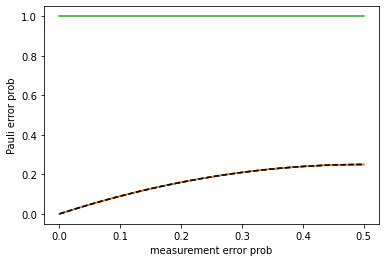

In [110]:
### algebra check for hadamard

Nq = 4
vec = Hilbertspace_Zr(Nq,2)

z1 = np.zeros((2,Nq+1),dtype=int)
x1 = np.zeros((2,Nq+1),dtype=int)
z2 = np.zeros((2,Nq+1),dtype=int)
x2 = np.zeros((2,Nq+1),dtype=int)
err_vec = np.zeros((4,Nq+1),dtype=int)
for i in range(2**Nq):
    s_flip=vec[i,:]
    sz = np.sum(vec[i,[0,2,3]])
    sx = np.sum(vec[i,[1,2]])
    p_exp = np.sum(vec[i,:])
    
    i_e = np.array([sz%2,sx%2])@ (2**np.arange(2))
    err_vec[i_e,p_exp] += 1
   
p_list = np.linspace(0,0.5)
err_prob = np.zeros((4,len(p_list)))
err_prob_ex = np.zeros((4,len(p_list)))
for i_p, p in enumerate(p_list):
    p_vec = p**np.arange(5)*(1-p)**np.arange(4,-1,-1)
    err_prob[:,i_p] = err_vec @ p_vec
    
    p_flip = p
    err_prob_ex[0,i_p] = (1-p_flip)**4 + 2*p_flip**3 * (1-p_flip) + p_flip**2 * (1-p_flip)**2 
    err_prob_ex[1,i_p] = 2*p_flip * (1-p_flip)**3 + p_flip**2 * (1-p_flip)**2 + p_flip**4
    err_prob_ex[2,i_p] = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
    err_prob_ex[3,i_p] = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)


plt.figure()
for i_e in [2,3]:
    plt.plot(p_list,err_prob[i_e,:],label="%d" % i_e)
    plt.plot(p_list,err_prob_ex[i_e,:],"k--")

plt.plot(p_list,np.sum(err_prob,axis=0))
# plt.plot(p_list,p_list*0+1/4,"k--")
plt.ylabel("Pauli error prob")
plt.xlabel("measurement error prob")
# plt.legend()
plt.show()

In [68]:

def Hilbertspace_Zr(N,r):
    states=np.zeros((r**N,N),dtype=int)
    if N>0:
        for i_1 in range(r**N):
            num_str=np.base_repr(i_1,base=r)[::-1]
            for i_2 in range(len(num_str)):
                states[i_1,i_2]=int(num_str[i_2])
    else:
        states=[[0]]
        
    return states

Nq = 14
vec = Hilbertspace_Zr(Nq,2)
err_vec = np.zeros((16,Nq+1),dtype=int)
for i in range(2**Nq):
    s_flip=vec[i,:]
    sz_c = np.sum(vec[i,[0,2,3,4,7,12]])
    sx_c = np.sum(vec[i,[1,2,4,5]])
    sz_t = np.sum(vec[i,[8,10,12]])
    sx_t = np.sum(vec[i,[4,5,7,9,11,13]])
    p_exp = np.sum(vec[i,:])
    
    i_e = np.array([sz_c%2,sx_c%2,sz_t%2,sx_t%2])@ (2**np.arange(4))
    err_vec[i_e,p_exp] += 1
p_vec = p_flip**np.arange(15)*(1-p_flip)**np.arange(14,-1,-1)
err_prob = err_vec @ p_vec
pauli_vec = Hilbertspace_Zr(4,2)
pauli_combined = []
for i in range(16):
    p_st = ''
    p1 = pauli_vec[i,:2]@ np.array([1,2])
    if  p1 == 0:
        p_st += 'I'
    elif  p1 == 1:
        p_st += 'Z'
    elif  p1 == 2:
        p_st += 'X'
    else:
        p_st += 'Y'
    p2 = pauli_vec[i,2:]@ np.array([1,2])
    if  p2 == 0:
        p_st += 'I'
    elif  p2 == 1:
        p_st += 'Z'
    elif  p2 == 2:
        p_st += 'X'
    else:
        p_st += 'Y'

    pauli_combined.append((p_st,err_prob[i]))
print(pauli_combined)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:

p =0.3
inds=np.argwhere(np.random.rand(4)<2*p/3)[:,0]
s_flip = np.zeros(4)
s_flip[inds] = 1
sx = (s_flip[1]+ s_flip[2]) % 2
sz = (s_flip[0]+ s_flip[2]+ s_flip[3]) % 2

α = 0.3
β = (1-np.abs(α)**2)**0.5

# output_vec = np.zeros(2,dtype=np.complex64)
if sx==0 and sz==0:
    inn_prod = 1
elif sx==0 and sz==1:
    inn_prod = np.abs(α)**2 -np.abs(β)**2
elif sx==1 and sz==0:
    inn_prod = 2*np.real(np.conj(α)*β)
    # output_vec = [β, α]
else:
    inn_prod = 2*np.imag(np.conj(α)*β)
    # output_vec = [β, -α]
# inn_prod= []@outputvec


    



